## GPT-2 Finetuning on Sentiment Classification

### Overview

- Compare performance of different text generation model on a sentiment detection task.
- For this, we will fine the text generation model GPT-2 on train data and report performance on the test data.
- Hence, we will also learn how to fine tune the TG models along wth how to apply these model to an example NLP task.

### Model

- Huggingface

### Dataset

- Tweet Sentiment

### Download and import packages

In [1]:
# uninstall
# !pip uninstall -y wandb

# # download
# !pip install transformers

# import
import re
import json
import torch
import random
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

### Dataset load and prep functions

In [2]:
# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, txt_list, label_list, tokenizer, max_length):
        # define variables    
        self.input_ids = []
        self.attn_masks = []
        self.labels = []
        map_label = {0:'negative', 4: 'positive'}
        # iterate through the dataset
        for txt, label in zip(txt_list, label_list):
            # prepare the text
            prep_txt = f'<|startoftext|>Review: {txt}\nSentiment: {map_label[label]}<|endoftext|>'
            # tokenize
            encodings_dict = tokenizer(prep_txt, truncation=True,
                                       max_length=max_length, padding="max_length")
            # append to list
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
            self.labels.append(map_label[label])

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx], self.labels[idx]

# Data load function
def load_sentiment_dataset(tokenizer, random_seed = 1):
    # load dataset and sample 10k reviews.
    df = pd.read_csv("../input/sentiment140/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1', header=None)
    df = df[[0, 5]]
    df.columns = ['label', 'text']
    df = df.sample(1000)
    
    df_test=pd.read_csv("../input/sentiment-test/testdata_manual_2009_06_14.csv", encoding='ISO-8859-1', header=None)
    df_test = df_test[[0, 5]]
    df_test.columns = ['label', 'text']
    
    def pick_first_n_words(string, max_words=250): # tried a few max_words, kept 250 as max tokens was < 512
        split_str = string.split()
        return " ".join(split_str[:min(len(split_str), max_words)])

    df['text'] = df['text'].apply(lambda x: pick_first_n_words(x))
    df_test['text'] = df_test['text'].apply(lambda x: pick_first_n_words(x))

    y_train= df['label']           
    X_train=df['text']  
    y_test =df_test['label']
    X_test = df_test['text']


    # get max length
    max_length_train = max([len(tokenizer.encode(text)) for text in X_train])
    max_length_test = max([len(tokenizer.encode(text)) for text in X_test])
    max_length = max([max_length_train, max_length_test]) + 10  #for special tokens (sos and eos) and fillers
    max_length = max(max_length, 300)
    print(f"Setting max length as {max_length}")

    # format into SentimentDataset class
    train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_length=max_length)

    # return
    return train_dataset, (X_test, y_test)

### Load model and tokenizer; Call data Prep

In [3]:
# import 
from torch.utils.data import Dataset, random_split
from transformers import GPT2Tokenizer, TrainingArguments, Trainer, GPT2LMHeadModel

# model
model_name = "gpt2"
# seed = 42

# # seed
# torch.manual_seed(seed)

In [4]:
train_losses = []
test_losses = []
test_acces=[]
# iterate for N trials
for trial_no in range(5):
    
    print("Loading model...")
    # load tokenizer and model
    tokenizer = GPT2Tokenizer.from_pretrained(model_name, bos_token='<|startoftext|>',
                                              eos_token='<|endoftext|>', pad_token='<|pad|>')
    model = GPT2LMHeadModel.from_pretrained(model_name).cuda()
    model.resize_token_embeddings(len(tokenizer))

    print("Loading dataset...")
    train_dataset, test_dataset = load_sentiment_dataset(tokenizer, trial_no)

    print("Start training...")
    training_args = TrainingArguments(output_dir='results', num_train_epochs=2, 
                                    logging_steps=200, load_best_model_at_end=True,
                                      save_strategy="epoch", per_device_train_batch_size=2, per_device_eval_batch_size=2,
                                    warmup_steps=100, weight_decay=0.01, logging_dir='logs')

    Trainer(model=model, args=training_args, train_dataset=train_dataset,
            eval_dataset=test_dataset, data_collator=lambda data: {'input_ids': torch.stack([f[0] for f in data]),
                                                                  'attention_mask': torch.stack([f[1] for f in data]),
                                                                  'labels': torch.stack([f[0] for f in data])}).train()
    
    # test
    print("Start testing...")
    # eval mode on model
    _ = model.eval()

    # compute prediction on test data
    original, predicted, all_text, predicted_text = [], [], [], []
    map_label = {0:'negative', 4: 'positive'}
    for text, label in tqdm(zip(test_dataset[0], test_dataset[1])):
        # predict sentiment on test data
        prompt = f'<|startoftext|>Review: {text}\nSentiment:'
        generated = tokenizer(f"<|startoftext|> {prompt}", return_tensors="pt").input_ids.cuda()
        sample_outputs = model.generate(generated, do_sample=False, top_k=50, max_length=512, top_p=0.90, 
                temperature=0, num_return_sequences=0)
        pred_text = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)
        # extract the predicted sentiment
        try:
            pred_sentiment = re.findall("\nSentiment: (.*)", pred_text)[-1]
        except:
            pred_sentiment = "None"
        original.append(map_label[label])
        predicted.append(pred_sentiment)
        all_text.append(text)
        predicted_text.append(pred_text)
    #transform into dataframe
    df = pd.DataFrame({'text': all_text, 'predicted': predicted, 'original': original, 'predicted_text': predicted_text})
    df.to_csv(f"result_run_{trial_no}.csv", index=False)
    # compute f1 score
    acc=f1_score(original, predicted, average='macro')
    test_acces.append(acc)
    print(acc)
    print('---------------------------------------------------',trial_no,'-------------------------------------------------------------------------')

Loading model...


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading dataset...
Setting max length as 300
Start training...


wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.13.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss
200,1.839900
400,0.351200
600,0.328600
800,0.317300
1000,0.308300


0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
2it [00:00, 17.84it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Start testing...


5it [00:00, 22.91it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
9it [00:00, 28.38it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
12it [00:00, 26.21it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
15it [00:00, 24.85it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256

0.837378944079975
--------------------------------------------------- 0 -------------------------------------------------------------------------
Loading model...


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Loading dataset...
Setting max length as 300
Start training...


Step,Training Loss
200,1.578700
400,0.379500
600,0.343200
800,0.300400
1000,0.324200


0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
3it [00:00, 21.98it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Start testing...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
6it [00:00, 25.91it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10it [00:00, 30.42it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
14it [00:00, 31.38it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

0.843980877879183
--------------------------------------------------- 1 -------------------------------------------------------------------------
Loading model...


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Loading dataset...
Setting max length as 300
Start training...


Step,Training Loss
200,1.578700
400,0.379500
600,0.343200
800,0.300400
1000,0.324200


0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
3it [00:00, 28.86it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Start testing...


7it [00:00, 32.25it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
11it [00:00, 30.92it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
15it [00:00, 27.68it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
18it [00:00, 26.02it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:5025

0.843980877879183
--------------------------------------------------- 2 -------------------------------------------------------------------------
Loading model...


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Loading dataset...
Setting max length as 300
Start training...


Step,Training Loss
200,1.578700
400,0.379500
600,0.343200
800,0.300400
1000,0.324200


0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
3it [00:00, 22.81it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Start testing...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
6it [00:00, 24.72it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
10it [00:00, 29.17it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
14it [00:00, 31.54it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

0.843980877879183
--------------------------------------------------- 3 -------------------------------------------------------------------------
Loading model...


Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


Loading dataset...
Setting max length as 300
Start training...


Step,Training Loss
200,1.578700
400,0.379500
600,0.343200
800,0.300400
1000,0.324200


0it [00:00, ?it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
4it [00:00, 34.37it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Start testing...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
8it [00:00, 28.30it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
11it [00:00, 26.46it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
14it [00:00, 25.13it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
17it [00:00, 24.52it/s]Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:5025

0.843980877879183
--------------------------------------------------- 4 -------------------------------------------------------------------------


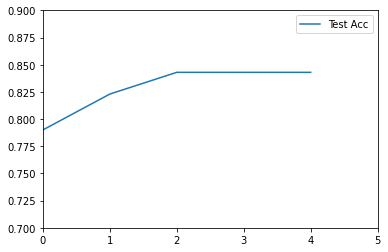

In [14]:
import matplotlib.pyplot as plt
# 绘制训练和测试损失的变化情况
# plt.plot(train_losses, label='Training loss')
# plt.plot(test_losses, label='Testing loss')
plt.plot(test_acces, label='Test Acc')
# plt.text(4, -0.2, "GPT2", ha='center', va='center')
# plt.text(4, -0.3, "200sample-10epoch", ha='center', va='center')
plt.xlim(0,5)
plt.ylim(0.7,0.9)
plt.legend()
plt.savefig('GPT2_0.843.png', bbox_inches='tight')
plt.show()

In [ ]:
# import os

# output_dir = './gpt-2-sentiment/'

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)